In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("always")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data/"))

# Any results you write to the current directory are saved as output.

/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


['train.csv']


In [2]:
#
# read sets into dataframes
# df_train = pd.read_csv('../input/train.csv')
# for running local
df_train = pd.read_csv('data/train.csv')
# df_test = pd.read_csv('../input/test.csv')
#
# basic information about the dataset
print("there are {0} question pairs in training and {1} columns".format(df_train.shape[0], df_train.shape[1]))
#print("there are {0} question pairs in testing and {1} columns".format(df_test.shape[0], df_test.shape[1]))
print("-------- TRAIN DATA TYPES --------")
print(df_train.dtypes)
#print("-------- TEST DATA TYPES --------")
#print(df_test.dtypes)
print("-------- TRAIN MISSING VALUES --------")
print(df_train.isnull().sum())
#print("-------- TEST MISSING VALUES --------")
#print(df_test.isnull().sum())

there are 404290 question pairs in training and 6 columns
-------- TRAIN DATA TYPES --------
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object
-------- TRAIN MISSING VALUES --------
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [3]:
#
# there are a small number of missing values, first i will see if it's just error and replace
# based on the question id
missingq1_qid1 = df_train.loc[df_train['question1'].isnull()]['qid1'].tolist()[0]
missingq2_qid2 = df_train.loc[df_train['question2'].isnull()]['qid2'].tolist()[0]   # this is the same question so just one item 
print("id for missing q1: {0}, id for missing q2: {1}".format(missingq1_qid1, missingq2_qid2))
#
# retrieve from dataset questions with previous ids (question 1 first)
if len(df_train.loc[(df_train['qid1'] == missingq1_qid1) & (df_train['id'] != df_train.loc[df_train['question1'].isnull()]['id'].tolist()[0])]) == 0:
    print("no question to replace missing q1")
else:
    print("replace missing q1 with question id: {}".format(df_train.loc[(df_train['qid1'] == missingq1_qid1) & (df_train['id'] != df_train.loc[df_train['question1'].isnull()]['id'].tolist()[0])]['id']))
#
# drop the missing values
df_train.dropna(inplace=True)
df_train = df_train.reset_index(drop=True)
print("-------- TRAIN MISSING VALUES --------")
print(df_train.isnull().sum())
print(df_train.shape)

id for missing q1: 493340, id for missing q2: 174364
no question to replace missing q1
-------- TRAIN MISSING VALUES --------
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
(404287, 6)


In [4]:
#
# as is_duplicate is our target and as a binary column we can compute the mean to get
# the percentage of duplicate question in the dataset
print("percentage of duplicate questions in dataset: {0}%".format(df_train['is_duplicate'].mean()*100))
print("-------- COUNT, UNIQUE, TOP AND FREQUENCY FOR QUESTIONS 1 --------")
print(df_train.qid1.astype(str).describe())
print("-------- COUNT, UNIQUE, TOP AND FREQUENCY FOR QUESTIONS 2 --------")
print(df_train.qid2.astype(str).describe())
print("top question 1 in dataset: \'{0}\'".format(df_train.loc[df_train['qid1'] == 8461, 'question1'].iloc[0]))
print("top question 2 in dataset: \'{0}\'".format(df_train.loc[df_train['qid2'] == 30782, 'question2'].iloc[0]))
print("-------- PERCENTAGE OF UNIQUE QUESTIONS --------")
print("Q1: {}%".format(df_train.qid1.astype(str).describe()['unique']/df_train.qid1.astype(str).describe()['count']*100))
print("Q2: {}%".format(df_train.qid2.astype(str).describe()['unique']/df_train.qid2.astype(str).describe()['count']*100))

percentage of duplicate questions in dataset: 36.92005926482919%
-------- COUNT, UNIQUE, TOP AND FREQUENCY FOR QUESTIONS 1 --------
count     404287
unique    290652
top         8461
freq          50
Name: qid1, dtype: object
-------- COUNT, UNIQUE, TOP AND FREQUENCY FOR QUESTIONS 2 --------
count     404287
unique    299362
top        30782
freq         120
Name: qid2, dtype: object
top question 1 in dataset: 'How do I improve my English speaking?'
top question 2 in dataset: 'How can you look at someone's private Instagram account without following them?'
-------- PERCENTAGE OF UNIQUE QUESTIONS --------
Q1: 71.89249221468907%
Q2: 74.04690232433889%


It seems that by categorizing these questions we can gain useful knowledge at a question level prior detecting if they are duplicate or not. As printed in the previous snippet, the top questions for both 1 and 2 belong to specific categories and very different from each other. One is essentially "language" category while the second one is "social media"

In [5]:
#
# visualization on unique questions and duplicate questions
# how many repeated questions q1 are duplicated
# how many repeated questions q2 are duplicated
# how many repeated questions q1 and q2 are duplicated
print(df_train.loc[df_train.duplicated('qid1')].is_duplicate.describe())
print(df_train.loc[df_train.duplicated('qid2')].is_duplicate.describe())
print(df_train.loc[df_train.duplicated('qid1') & df_train.duplicated('qid2')].is_duplicate.describe())

count    113635.000000
mean          0.590012
std           0.491833
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_duplicate, dtype: float64
count    104925.000000
mean          0.639981
std           0.480008
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_duplicate, dtype: float64
count    61324.000000
mean         0.811151
std          0.391392
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: is_duplicate, dtype: float64


In [6]:
#
# visualization on unique questions and duplicate questions
# how many unique questions q1 are duplicated
# how many unique questions q2 are duplicated
# how many unique questions q1 and q2 are duplicated
print(df_train.loc[df_train.duplicated('qid1') == False].is_duplicate.describe())
print(df_train.loc[df_train.duplicated('qid2') == False].is_duplicate.describe())
print(df_train.loc[(df_train.duplicated('qid1') == False) & (df_train.duplicated('qid2') == False)].is_duplicate.describe())

count    290652.000000
mean          0.282871
std           0.450395
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_duplicate, dtype: float64
count    299362.000000
mean          0.274293
std           0.446158
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_duplicate, dtype: float64
count    247051.000000
mean          0.262334
std           0.439904
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_duplicate, dtype: float64


In [7]:
#
# number of words per question (withouth pre-processing)
import spacy
nlp = spacy.load('en')
#
# tokenize words in question1 and quetion2 and get the length of tokens 
df_train['length_question1'] = df_train['question1'].apply(lambda x: len(nlp(x,  disable=['parser', 'tagger', 'ner'])))
df_train['length_question2'] = df_train['question2'].apply(lambda x: len(nlp(x,  disable=['parser', 'tagger', 'ner'])))

/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anac

/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs

/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: PendingDeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/msgpack_numpy.py:184: 

/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

question 1 length mean: 12.534108195415634 and median: 11.0
question 2 length mean: 12.796384746479605 and median: 11.0
maximum length for question 1: 146, question: 
Like everyone else (here in U.S), I work with a group of people I see and interact with every day. As a human rights advocate and Lesbian, my views are liberal and I by no means preach my beliefs in my work place. However, I want to know, when is it OK to state your opinions on an issue. For example, if someone mentions that their next door neighbor, who happens to be a 12 year old boy, was playing with dolls and that "this is going down the wrong road and he is strange/weird", is it OK for me to say that we shouldn't judge him for who he is? So confused... This just happened at lunch and I am very upset about it...

maximum length for question 2: 271, question: 
Heartbreak? Heartbreak? She's my girlfriend for two months, I chose her over my girlfriend for 2 years. I like her so much to the point that I can't let her go e

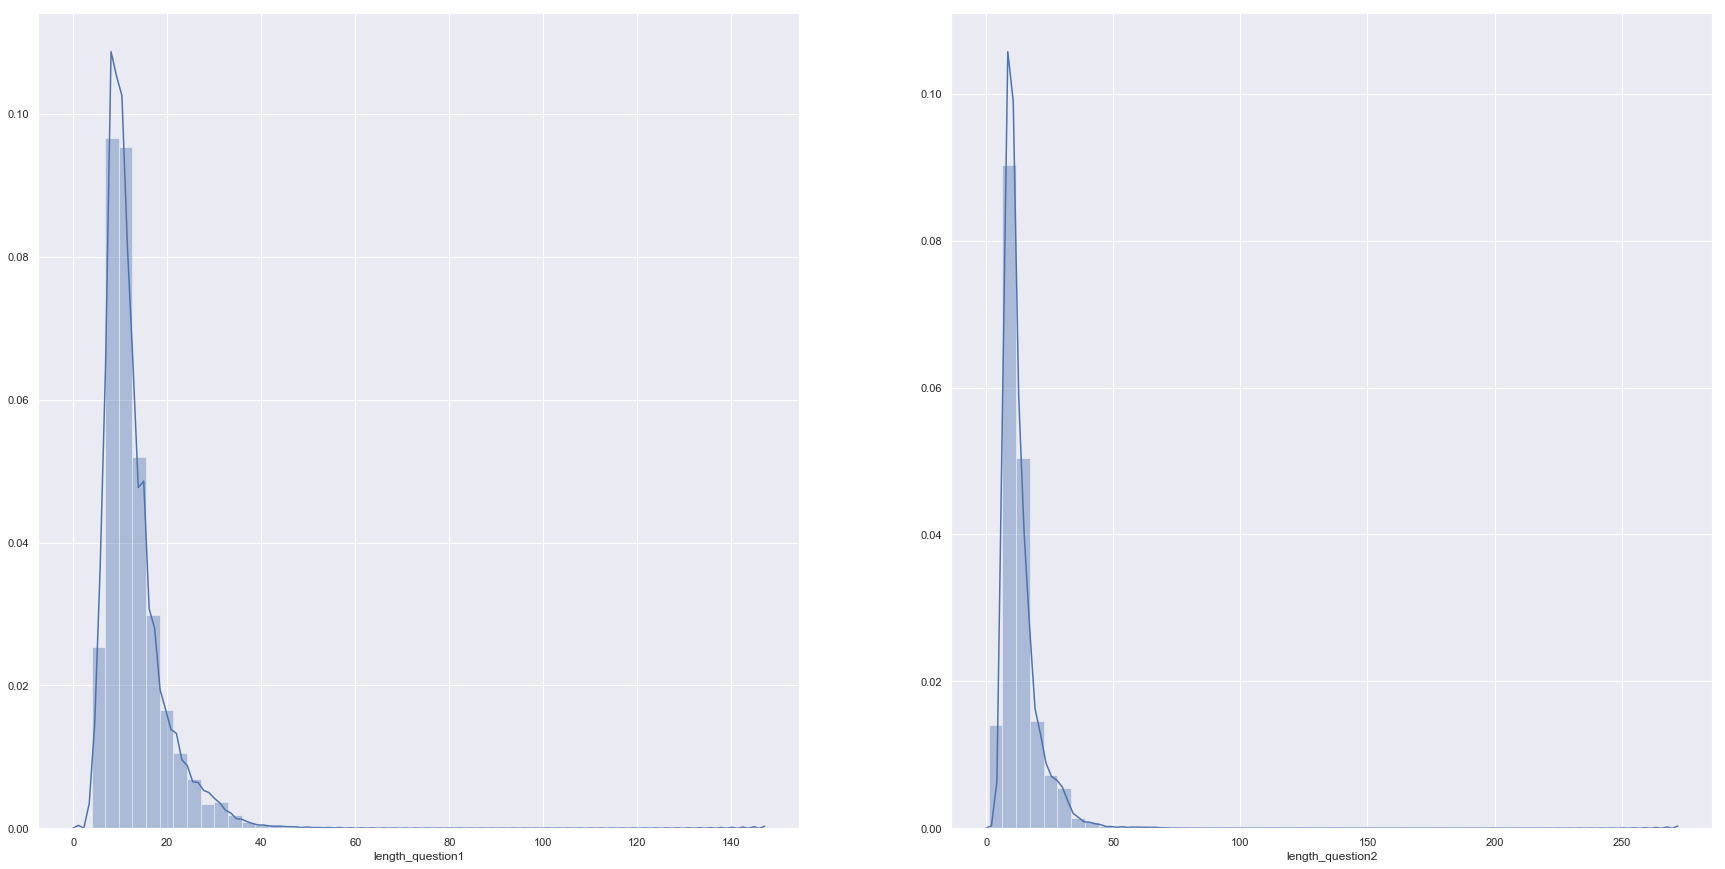

In [10]:
#
# Visualizing the distribution of variables in dataset
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

np.random.seed(sum(map(ord, "distributions")))

fig, ax = plt.subplots(1,2,figsize=(30,15))
# frequency density on y axis
sns.distplot(ax=ax[0], bins=50, a=df_train['length_question1'])
sns.distplot(ax=ax[1], bins=50, a=df_train['length_question2'])
print("question 1 length mean: {0} and median: {1}".format(df_train['length_question1'].mean(), df_train['length_question1'].median()))
print("question 2 length mean: {0} and median: {1}".format(df_train['length_question2'].mean(), df_train['length_question2'].median()))
print("maximum length for question 1: {0}, question: \n{2}\n\nmaximum length for question 2: {1}, question: \n{3}".format(df_train['length_question1'].max(), df_train['length_question2'].max(), df_train.loc[df_train['length_question1'] == 146].question1.item(), df_train.loc[df_train['length_question2'] == 271].question2.iloc[0]))

Univariate distribution for both questions length skewed right, mean is towards the right and median closer to the pick (both containing the same median). questions length for second set are similar distributed with the question lenght from the first set. duplicated question 2 for the same length, none of the highest values are find duplicates in the training dataset.

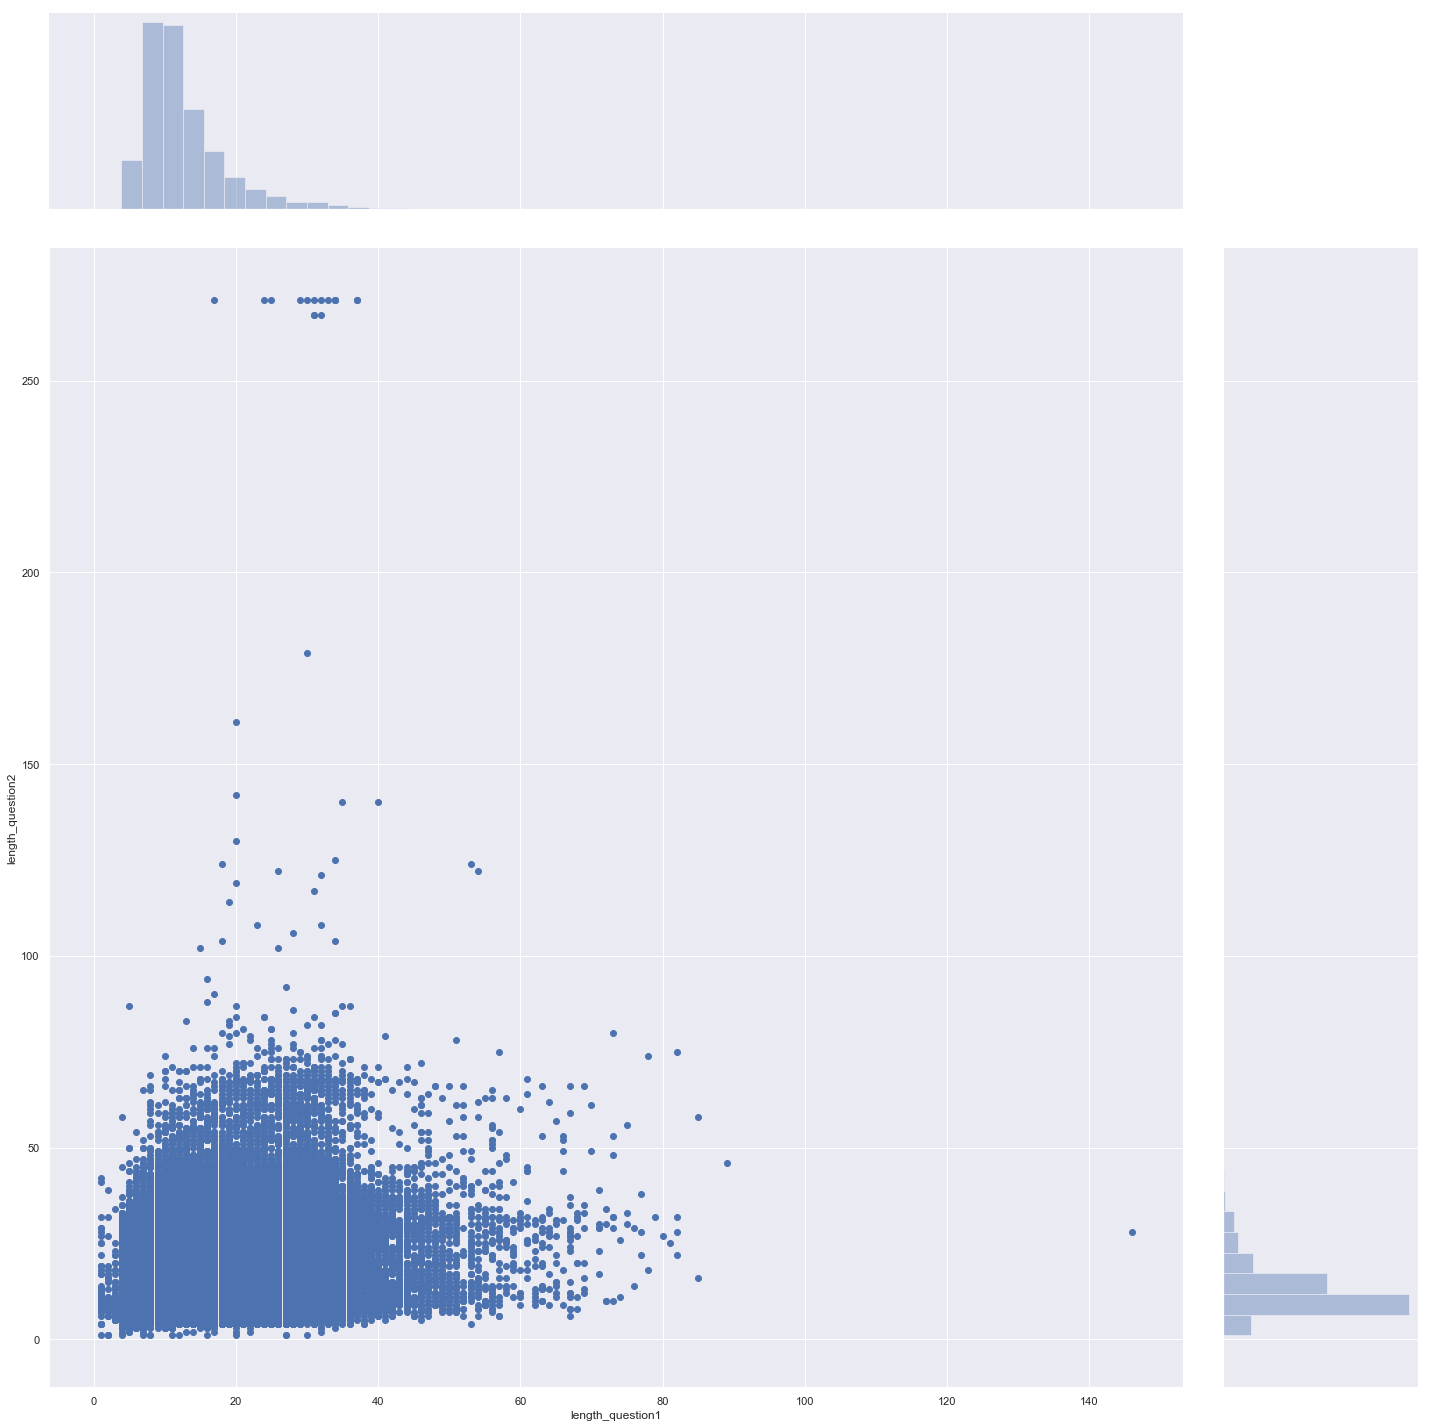

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#
# scatter plot to see the relation of both questions length in each axis
sns.jointplot(height=20, ratio=5, x="length_question1", y="length_question2", data=df_train[['length_question1', 'length_question2']]);

Without cleaning stopwords and pre-processing text i want to see how length of both questions relate to the target variable (is_duplicate)

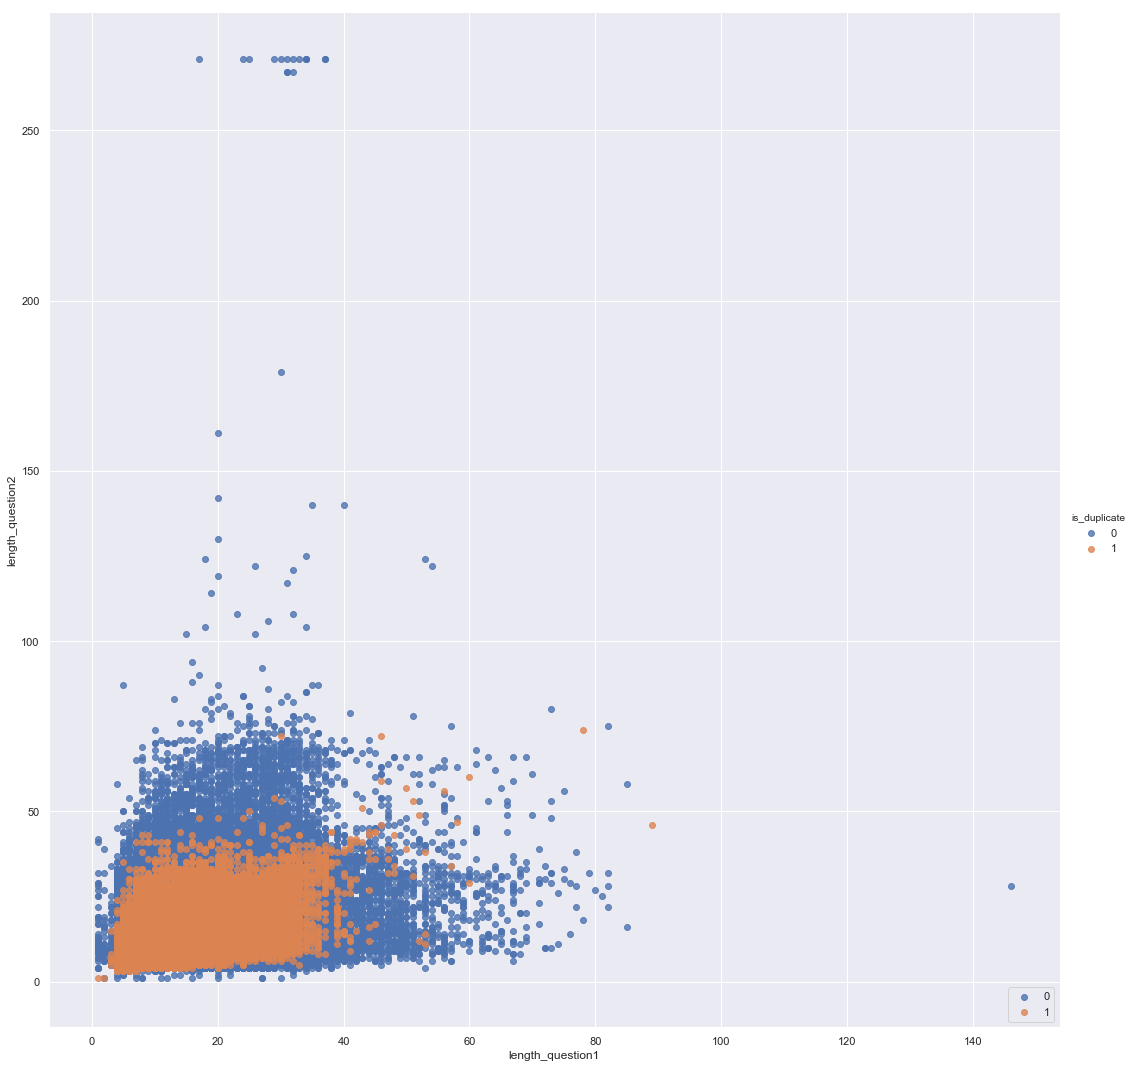

In [12]:
warnings.simplefilter(action='ignore', category=UserWarning)
#
# scatter plot for both variables, color by is_duplicate or not
sns.lmplot(x="length_question1", y="length_question2", data=df_train[['length_question1', 'length_question2', 'is_duplicate']],
           fit_reg=False, hue='is_duplicate', legend=True, size=15)
#
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

Most duplicate questions appear in the range of the same length and in the other side questions with substantial difference in length can mean different questions. it would be a good excercise to plot this difference.

,length_question1,length_question2,length_difference_q12,is_duplicate
length_question1,1.000000,0.462468,0.441186,-0.167746
length_question2,0.462468,1.000000,0.578489,-0.171509
length_difference_q12,0.441186,0.578489,1.000000,-0.206474
is_duplicate,-0.167746,-0.171509,-0.206474,1.000000


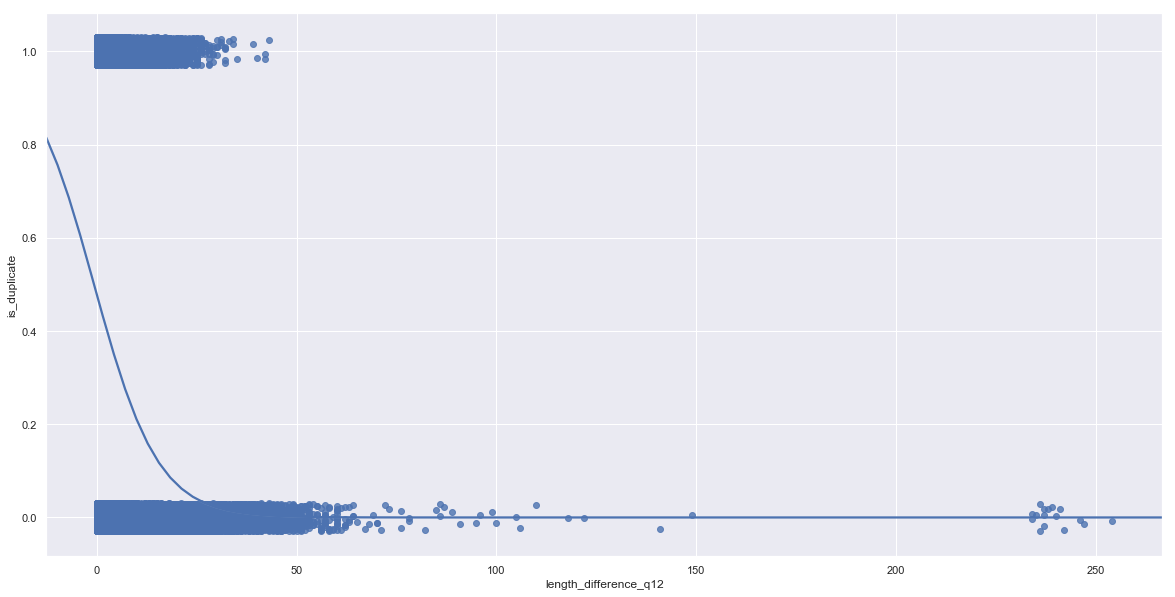

In [13]:
#
# caluclate the difference in between lengths for questions (1 and 2)
df_train['length_difference_q12'] = abs(df_train['length_question1'] - df_train['length_question2'])
#
# plot the absolute difference in between the lengths of questions
plt.figure(figsize=(20,10))
sns.regplot(data=df_train, x="length_difference_q12", y="is_duplicate", logistic=True, n_boot=500, y_jitter=.03)
#
# print correlation matrix
df_train[['length_question1', 'length_question2', 'length_difference_q12', 'is_duplicate']].corr()

I can see that duplicate questions tend to appear when the difference of their lengths is less than 40~ but at the same time not duplicate questions tend to happen too with this criteria, in less proportion but not fully a rule. This also can happen becuase most of the questions tend to have similar lengths and in previous plots i can also see that only a few cases have substantial differences on length.
From previous results and final correlation, i conclude that:
* the pearson correlation between question length 1 and 2 is about 0.462468, which indicates that there is a moderate positive relationship between the variables.
* the pearson correlation between difference in lengths and is duplicate is about -0.206474, as a negative value, indicates that as the difference increases, the target value decreases, this actually makes sense as lower distance of length can represent similar questions (1 for is_duplicate) while substantial differences on length tend to be different questions (0 for is_duplicate)

Now that i have a baseline on the question lengths in both sides as a good indicator of a duplicate question, i can focus on the rest of the features related to natural language processing. For the first task I will find relevant words, ngrams and how they interact in between questions and within the target value.

/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


(-0.5, 1919.5, 1079.5, -0.5)

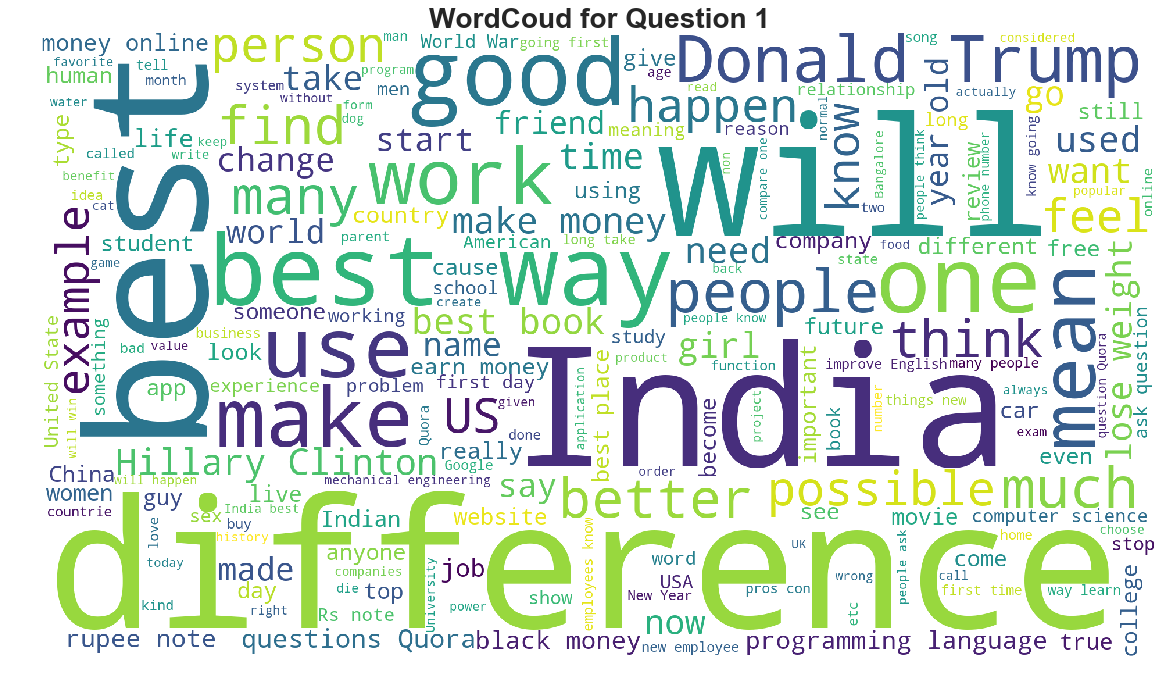

In [14]:
from wordcloud import WordCloud
#
# create corpus for both set of questions
question1_corpus = " ".join(df_train['question1'].tolist())
question2_corpus = " ".join(df_train['question2'].tolist())
#
# wordcloud
cloud_1 = WordCloud(width=1920, height=1080, background_color="white", mode="RGB").generate(question1_corpus)
cloud_2 = WordCloud(width=1920, height=1080, background_color="white", mode="RGB").generate(question2_corpus)
# plot definitions
font = {'weight': 'bold', 'size': 28}
plt.figure(figsize=(20, 15))
plt.title("WordCoud for Question 1", loc="center", fontdict=font)
plt.imshow(cloud_1)
plt.axis("off")

(-0.5, 1919.5, 1079.5, -0.5)

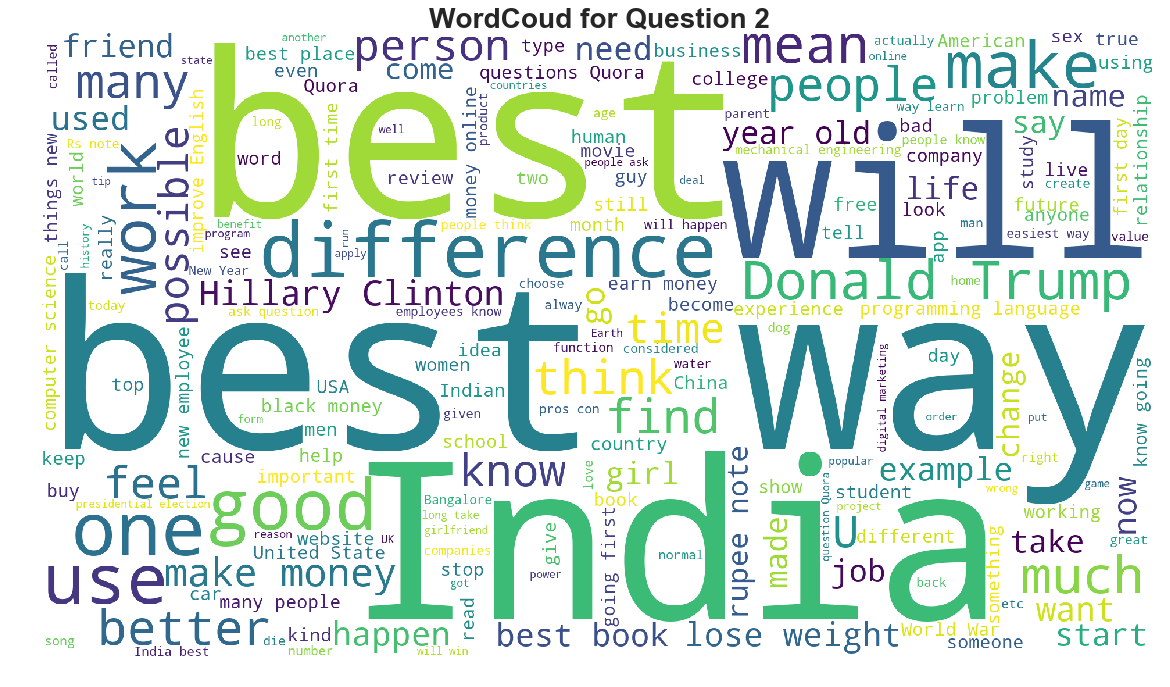

In [15]:
# wordcloud for question 2
plt.figure(figsize=(20, 15))
plt.title("WordCoud for Question 2", loc="center", fontdict=font)
plt.imshow(cloud_2)
plt.axis("off")

Total naive tokens in corpus 8946783


(-0.5, 1919.5, 1079.5, -0.5)

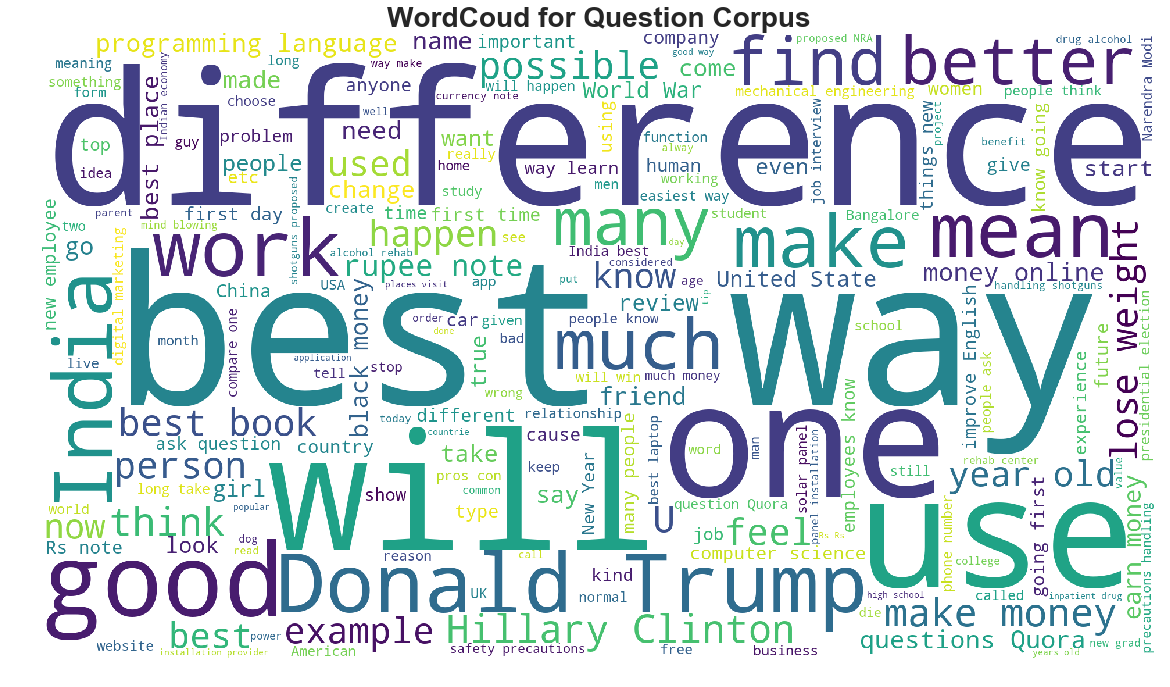

In [16]:
questions_corpus = question1_corpus + question2_corpus
print("Total naive tokens in corpus {}".format(len(questions_corpus.split(" "))))
cloud = WordCloud(width=1920, height=1080, background_color="white", mode="RGB").generate(questions_corpus)
# plot definitions
font = {'weight': 'bold', 'size': 28}
plt.figure(figsize=(20, 15))
plt.title("WordCoud for Question Corpus", loc="center", fontdict=font)
plt.imshow(cloud)
plt.axis("off")

I would also like to see how these terms interact with each other, I will use NLTK to plot to most frequent ngrams

In [20]:
import re
import contractions
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
#
# pre-process text to fix contractions and remove question marks and non alphanumeric characters
# to not sum them in the grams as corpus was joint into one
questions_corpus = contractions.fix(questions_corpus)
questions_corpus = re.sub(r'[^A-Za-z0-9]', ' ',questions_corpus)
# tokenize resulting corpus by words
token = nltk.word_tokenize(questions_corpus)
# build ngrams for 3, 4 and 5 windows
trigrams = ngrams(token,3)
fourgrams = ngrams(token,4)
fivegrams = ngrams(token,5)
trigram_counter = Counter(trigrams)
fourgram_counter = Counter(fourgrams)
fivegram_counter = Counter(fivegrams)

In [21]:
tgc_t10 = trigram_counter.most_common(10)
fgc_t10 = fourgram_counter.most_common(10)
ftgc_10 = fivegram_counter.most_common(10)
print("------ TRIGRAM ------")
for idx in range(0, len(tgc_t10)):
    print("Word Combination {0}, frequency: {1}".format(tgc_t10[idx][0],tgc_t10[idx][1]))
print("------ FOURGRAM ------")
for idx in range(0, len(fgc_t10)):
    print("Word Combination {0}, frequency: {1}".format(fgc_t10[idx][0],fgc_t10[idx][1]))
print("------ FIVEGRAM ------")
for idx in range(0, len(ftgc_10)):
    print("Word Combination {0}, frequency: {1}".format(ftgc_10[idx][0],ftgc_10[idx][1]))

------ TRIGRAM ------
Word Combination ('What', 'is', 'the'), frequency: 71639
Word Combination ('How', 'do', 'I'), frequency: 51275
Word Combination ('What', 'are', 'the'), frequency: 45911
Word Combination ('How', 'can', 'I'), frequency: 39185
Word Combination ('is', 'the', 'best'), frequency: 35701
Word Combination ('What', 'are', 'some'), frequency: 31672
Word Combination ('are', 'the', 'best'), frequency: 17688
Word Combination ('How', 'do', 'you'), frequency: 15622
Word Combination ('Which', 'is', 'the'), frequency: 11083
Word Combination ('the', 'difference', 'between'), frequency: 10953
------ FOURGRAM ------
Word Combination ('What', 'is', 'the', 'best'), frequency: 20562
Word Combination ('What', 'are', 'the', 'best'), frequency: 14417
Word Combination ('is', 'the', 'difference', 'between'), frequency: 10668
Word Combination ('Which', 'is', 'the', 'best'), frequency: 9214
Word Combination ('What', 'is', 'the', 'difference'), frequency: 9174
Word Combination ('is', 'the', 'bes

By looking at the questions, high frequency for the following types:
    * what is/are
    * How do/can
    * which
all these are related to also the "difference between" and I would asume that similarities can happen over "best way", so in logical terms having this structure:
    * type of question (what, how, which) --> best ways in between --> difference in between
can be a big indicator if these question are duplicates or not, so i will use this information to see in percentages of both questions set.

In [22]:
df_questions = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())
#
# who, what, where, which, when, why, how, best way(s)?, difference between in the entire dataset
print("WHAT {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'what' in x.lower()))*100))
print("\t*WHAT IS or ARE {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'what is' in x.lower() or 'what are' in x.lower()))*100))
print("WHO {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'who' in x.lower()))*100))
print("WHERE {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'where' in x.lower()))*100))
print("WHICH {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'which' in x.lower()))*100))
print("WHEN {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'when' in x.lower()))*100))
print("WHY {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'why' in x.lower()))*100))
print("HOW {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'how' in x.lower()))*100))
print("BEST WAY OR WAYS {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'best way' in x.lower()))*100))
print("DIFFERENCE BETWEEN {:.2f}%".format(np.mean(df_questions.apply(lambda x: 'difference between' in x.lower()))*100))
# questions with math marks
print("[MATH] {:.2f}%".format(np.mean(df_questions.apply(lambda x: '[math]' in x.lower()))*100))

WHAT 39.40%
	*WHAT IS or ARE 25.67%
WHO 3.39%
WHERE 2.23%
WHICH 5.36%
WHEN 3.20%
WHY 10.12%
HOW 27.26%
BEST WAY OR WAYS 1.43%
DIFFERENCE BETWEEN 1.56%
[MATH] 0.12%


In [23]:
#
# question 1 variable
df_train['what_q1'] = df_train['question1'].apply(lambda x: 'what' in x.lower()).astype(int)
df_train['who_q1'] = df_train['question1'].apply(lambda x: 'who' in x.lower()).astype(int)
df_train['where_q1'] = df_train['question1'].apply(lambda x: 'where' in x.lower()).astype(int)
df_train['which_q1'] = df_train['question1'].apply(lambda x: 'which' in x.lower()).astype(int)
df_train['when_q1'] = df_train['question1'].apply(lambda x: 'when' in x.lower()).astype(int)
df_train['why_q1'] = df_train['question1'].apply(lambda x: 'why' in x.lower()).astype(int)
df_train['how_q1'] = df_train['question1'].apply(lambda x: 'how' in x.lower()).astype(int)
df_train['best_way_q1'] = df_train['question1'].apply(lambda x: 'best way' in x.lower()).astype(int)
df_train['diff_between_q1'] = df_train['question1'].apply(lambda x: 'difference between' in x.lower()).astype(int)
#
# question 2 variables
df_train['what_q2'] = df_train['question2'].apply(lambda x: 'what' in x.lower()).astype(int)
df_train['who_q2'] = df_train['question2'].apply(lambda x: 'who' in x.lower()).astype(int)
df_train['where_q2'] = df_train['question2'].apply(lambda x: 'where' in x.lower()).astype(int)
df_train['which_q2'] = df_train['question2'].apply(lambda x: 'which' in x.lower()).astype(int)
df_train['when_q2'] = df_train['question2'].apply(lambda x: 'when' in x.lower()).astype(int)
df_train['why_q2'] = df_train['question2'].apply(lambda x: 'why' in x.lower()).astype(int)
df_train['how_q2'] = df_train['question2'].apply(lambda x: 'how' in x.lower()).astype(int)
df_train['best_way_q2'] = df_train['question2'].apply(lambda x: 'best way' in x.lower()).astype(int)
df_train['diff_between_q2'] = df_train['question2'].apply(lambda x: 'difference between' in x.lower()).astype(int)
#
# creation of new dataframe containing new features and target
df_train_q12_ = df_train.iloc[:,9:27].copy()
df_train_q12_['is_duplicate'] = df_train['is_duplicate']
#
# uncomment to get the correlation of each of these variables within the target
# df_train_q12_.corr()
#
# create new dataframe for combining both set of question's features true if both features are present, 
# false if either is missing
df_train_q12 = pd.DataFrame(df_train['is_duplicate'])
df_train_q12['what_q12'] = df_train_q12_['what_q1']*df_train_q12_['what_q2']
df_train_q12['who_q12'] = df_train_q12_['who_q1']*df_train_q12_['who_q2']
df_train_q12['where_q12'] = df_train_q12_['where_q1']*df_train_q12_['where_q2']
df_train_q12['which_q12'] = df_train_q12_['which_q1']*df_train_q12_['which_q2']
df_train_q12['when_q12'] = df_train_q12_['when_q1']*df_train_q12_['when_q2']
df_train_q12['why_q12'] = df_train_q12_['why_q1']*df_train_q12_['why_q2']
df_train_q12['how_q12'] = df_train_q12_['how_q1']*df_train_q12_['how_q2']
df_train_q12['best_way_q12'] = df_train_q12_['best_way_q1']*df_train_q12_['best_way_q2']
df_train_q12['diff_between_q12'] = df_train_q12_['diff_between_q1']*df_train_q12_['diff_between_q2']

In [24]:
#
# append last features to the train dataframe
df_train = df_train.join(df_train_q12[['what_q12', 'who_q12', 'where_q12', 'which_q12', 'when_q12', 'why_q12', 'how_q12', 'best_way_q12', 'diff_between_q12']], how='inner')

In [25]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_question1,length_question2,length_difference_q12,what_q1,...,diff_between_q2,what_q12,who_q12,where_q12,which_q12,when_q12,why_q12,how_q12,best_way_q12,diff_between_q12
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,15,13,2,1,...,0,1,0,0,0,0,0,0,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,15,20,5,1,...,0,1,0,0,0,0,0,0,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,15,11,4,0,...,0,0,0,0,0,0,0,1,0,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,13,12,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,16,8,8,0,...,0,0,0,0,1,0,0,0,0,0


After crafting these features, it would be a good excercise to see repeated terms in both questions, count them and see how they affect the target value. Duplicate questions can share similar structures but one specific word can make a total different question, for example **"What is the step by step guide to invest in share market in india?"** and **"What is the step by step guide to invest in share market?"**.

Before moving to specific weights on terms and entities, I will need to remove stopwords that will make many words to be repeated for both sets.

In [27]:
import nltk
from nltk.corpus import stopwords

# turn stopwords list into a set for performance
stops = set(stopwords.words('english'))
#
# testing with one example from dataframe
q1_1 = contractions.fix(df_train['question1'][0])
q2_1 = contractions.fix(df_train['question2'][0])
q1_1 = re.sub(r'[^A-Za-z0-9]', ' ',q1_1)
q2_1 = re.sub(r'[^A-Za-z0-9]', ' ',q2_1)
#
# tokenize resulting corpus by words
words_1 = nltk.word_tokenize(q1_1)
words_2 = nltk.word_tokenize(q2_1)
#
# build ngrams for 3, 4 and 5 windows
words_1 = [w for w in words_1 if w not in stops]
words_2 = [w for w in words_2 if w not in stops]
#
# question1 result
question1_result = " ".join(words_1)
question2_result = " ".join(words_2)
print(question1_result)
print(question2_result)

What step step guide invest share market india
What step step guide invest share market


/anaconda3/envs/NLP-Py36/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/cesar/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [28]:
# function to replicate process from above (clean stopwords)
def remove_stopwords(text):
    # fix contractions
    no_contractions = contractions.fix(text)
    #
    # remove non-alphanumeric words - this might led to the removal of シ, し  -> &, and as 
    # an example of question index 8
    only_words = re.sub(r'[^A-Za-z0-9]', ' ', no_contractions)
    #
    # lowercase
    only_words_lowercase = only_words.lower()
    #
    # tokenize question
    words = nltk.word_tokenize(only_words_lowercase)
    #
    # remove stopwords
    words = [w for w in words if w not in stops]
    #
    # return clean question
    return words

# function to clean stopwords and prepare text for the extraction of token's features using spacy
def preprocess_question(text):
    #
    # using spacy to create linguistic features
    doc = nlp(text)
    #
    # root, no stopwords no punctuation
    words = [token.lemma_ for token in doc if not token.is_stop and token.pos_ != 'PUNCT']
    #
    # count of stopwords
    nbr_stopwords = len([token.lemma_ for token in doc if token.is_stop])
    #
    # part of the speech
    pos_tags = [token.pos_ for token in doc]
    #
    # entities
    entities = [ent.text for ent in doc.ents]
    #
    # entity types
    ent_types = [ent.label_ for ent in doc.ents]
    #
    return words, nbr_stopwords, pos_tags, entities, ent_types

Now that I have the process above wrapped in a function I can apply it to the entire dataframe for both set of questions

In [29]:
import time

question1_nosw = []
question2_nosw = []
# measure time
t = time.process_time()
for idx in range(0, df_train['id'].size):
    question1_nosw.append(remove_stopwords(df_train['question1'][idx]))
    question2_nosw.append(remove_stopwords(df_train['question2'][idx]))
elapsed_time = time.process_time() - t
print("elapsed time %.2f seconds" % elapsed_time)

elapsed time 182.44 seconds


In [ ]:
q1_processed_mtx = []
q2_processed_mtx = []
t = time.process_time()
# measure time for each loop
for idx in range(0, df_train['id'].size):
    if (idx+1)%100000 == 0 :
        print("question set {0} of {1}\n".format(str(idx+1), str(df_train['id'].size)))
        elapsed_time = time.process_time() - t
        print("elapsed time %.2f seconds" % elapsed_time)
    q1_processed_mtx.append(preprocess_question(df_train['question1'][idx]))
    q2_processed_mtx.append(preprocess_question(df_train['question2'][idx]))
    elapsed_time = time.process_time() - t